# 卷积神经网络的原理
- 1. Filter Size: Width Height
- 2. Filter Number
- 3. Channel
- 4. Paddding Size
- 5. Pooling Size
- 6. Fully Connected


In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import torchvision

### LE-NET 5
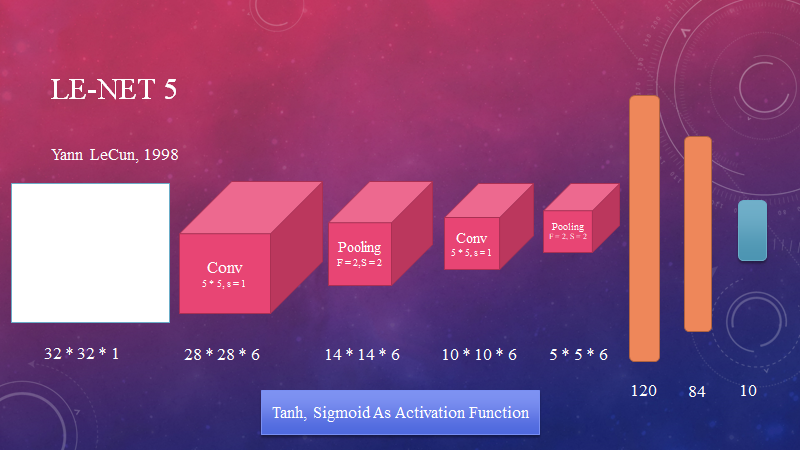

### Alex-NET
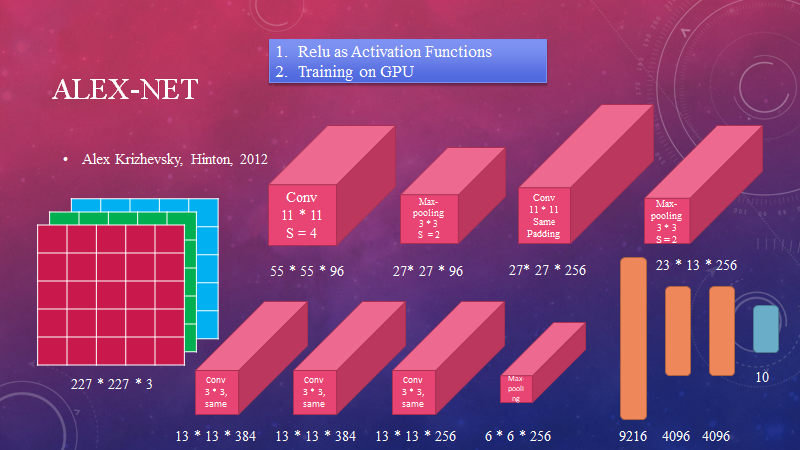

### VGG-NET
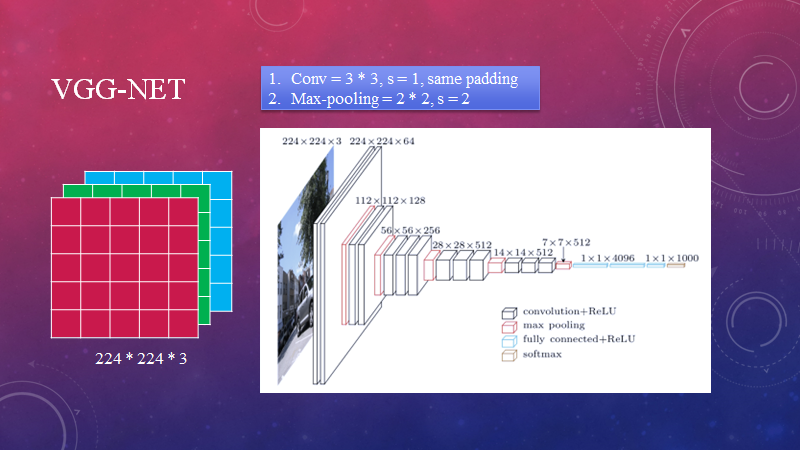

### RES-NET
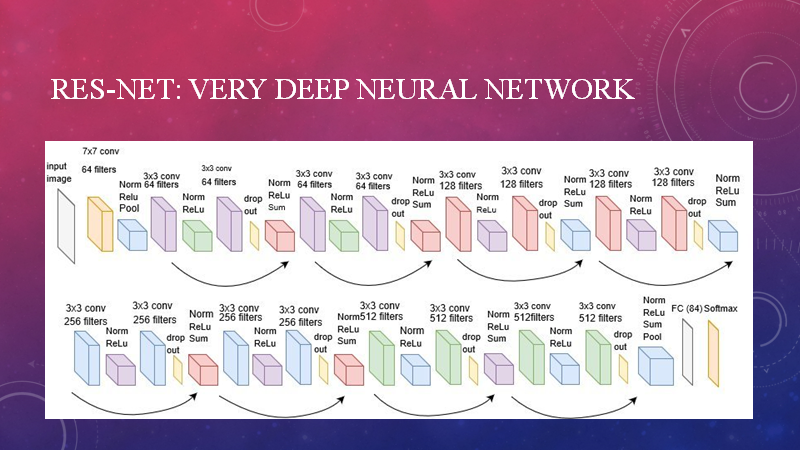

In [86]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 28, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(28, 8, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(4 * 4 * 8, 32)
        self.fc2 = nn.Linear(32, 10)
    
    def forward(self, x):
        out = F.max_pool2d(self.relu(self.conv1(x)), 2)
        out = F.max_pool2d(self.relu(self.con2(out)), 2)
        res = out
        out = F.max_pool2d(self.relu(self.conv3(out)) + res, 2)
        out = out.view(-1, 4 * 4 * 8)
        out = nn.Tanh(self.fc1(out))
        out = nn.fc2(out)
        
        return out


class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_normal = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_normal.weight, 0.5)
        torch.nn.init.zeros_(self.batch_normal.bias)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_normal(out)
        out = torch.relu(out)
        return out + x


class NetResDeep(nn.Module):
    def __init__(self, n_chans=32, n_blacks=10):
        super(NetResDeep, self).__init__()
        self.n_chans = n_chans
        self.conv = nn.Conv2d(1, n_chans, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *[ResBlock(n_chans=n_chans) for _ in range(n_blacks)]
        )
        self.fc1 = nn.Linear(7 * 7 * n_chans, 32)
        self.fc2 = nn.Linear(32, 36)
    
    def forward(self, x):
        print(x.size())
        out = F.max_pool2d(torch.relu(self.conv(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 7 * 7 * self.n_chans)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        out = torch.log_softmax(out, dim=1)
        return out

In [87]:
import pickle
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

train_data_dir = "../04_CNN/01_data/train_data.bin"
val_data_dir = "../04_CNN/01_data/val_data.bin"
verification_code_dir = "../04_CNN/01_data/verification_code_data.bin"

def load_file(filename):
    with open(filename, 'rb') as f:
        result = pickle.load(f)
    return result

char_dict = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,
             'A':10,'B':11,'C':12,'D':13,'E':14,'F':15,'G':16,'H':17,'I':18,
             'J':19,'K':20,'L':21,'M':22,'N':23,'O':24,'P':25,'Q':26,'R':27,
             'S':28,'T':29,'U':30,'V':31,'W':32,'X':33,'Y':34,'Z':35}
new_char_dict = {v: k for k, v in char_dict.items()}

class MyDataset(Dataset):
    def __init__(self, filename, transforms):
        self.filename = filename
        self.image_label_arr = load_file(self.filename) # 读入二进制文件
        self.transforms = transforms    # 图片转换器

    def __getitem__(self, index):
        label, img = self.image_label_arr[index]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = cv2.medianBlur(img, ksize=3)
        img = self.transforms(img)
        return img, char_dict[label[0]]

    def __len__(self):
        return len(self.image_label_arr)

transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize([28, 28]),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=0.5)])

train_datasets = MyDataset(train_data_dir, transform)
train_loader = DataLoader(dataset=train_datasets, batch_size=32, shuffle=True)

val_datasets = MyDataset(val_data_dir, transform)
val_loader = DataLoader(dataset=val_datasets, batch_size=32, shuffle=True)

In [88]:
res_model = ResNet()
deep_res_model = NetResDeep()

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(res_model.parameters(), lr=1e-3)

losses = []

epochs = 50


for epoch in range(epochs):
    deep_res_model.train()
    for batch_idx , (data, target) in enumerate(train_loader):
        # 1. 清空梯度
        optimizer.zero_grad()
        # 2. 前向传播
        output = deep_res_model(data)
        # 3. 计算loss
        loss = F.nll_loss(output, target)
        # 4. 反向传播计算梯度
        loss.backward()
        optimizer.step()

        if (batch_idx + 1) % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 0 [288/1800 (16%)]	Loss: 3.631356
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 0 [608/1800 (33%)]	Loss: 3.692478
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 0 [928/1800 (51%)]	Loss: 3.688780
torch.Size([32, 1, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 4 [1248/1800 (68%)]	Loss: 3.703171
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 4 [1568/1800 (86%)]	Loss: 3.737550
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 9 [288/1800 (16%)]	Loss: 3.665238
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 9 [608/1800 (33%)]	Loss: 3.755552
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 9 [928/1800 (51%)]	Loss: 3.603612
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 13 [1248/1800 (68%)]	Loss: 3.661767
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 13 [1568/1800 (86%)]	Loss: 3.860852
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.S

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 18 [288/1800 (16%)]	Loss: 3.608978
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 18 [608/1800 (33%)]	Loss: 3.630466
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 18 [928/1800 (51%)]	Loss: 3.612056
torch.Size([32, 1, 28, 28])
torch.Size([32, 

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 22 [928/1800 (51%)]	Loss: 3.729254
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 22 [1248/1800 (68%)]	Loss: 3.550405
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 22 [1568/1800 (86%)]	Loss: 3.668504
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32,

torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 27 [288/1800 (16%)]	Loss: 3.572092
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 27 [608/1800 (33%)]	Loss: 3.657294
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epo

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 31 [928/1800 (51%)]	Loss: 3.871608
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 31 [1248/1800 (68%)]	Loss: 3.810197
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 31 [1568/1800 (86%)]	Loss: 3.738316
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32,

torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 36 [288/1800 (16%)]	Loss: 3.674905
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 36 [608/1800 (33%)]	Loss: 3.689305
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 36 [928/1800 (51%)]	Loss

torch.Size([32, 1, 28, 28])
Train Epoch: 40 [928/1800 (51%)]	Loss: 3.662910
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 40 [1248/1800 (68%)]	Loss: 3.832871
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 40 [1568/1800 (86%)]	Loss: 3.631693
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32,

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([8, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 45 [288/1800 (16%)]	Loss: 3.891326
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 45 [608/1800 (33%)]	Loss: 3.683505
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Siz

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 49 [928/1800 (51%)]	Loss: 3.855915
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 49 [1248/1800 (68%)]	Loss: 3.646433
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
Train Epoch: 49 [1568/1800 (86%)]	Loss: 3.731045
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32

In [90]:
import matplotlib.pyplot as plt
# 验证码是被结果
IMAGES = list()
NUMS = list()
def recognize_verification_code(model, verification_code_data):
    for img in verification_code_data:
        IMAGES.append(img)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        image_1 = img[:, :80]
        image_2 = img[:, 80:160]
        image_3 = img[:, 160:240]
        image_4 = img[:, 240:320]
        img_list = [image_1, image_2, image_3, image_4]

        nums = []
        for one_img in img_list:
            one_img = transform(one_img)
            one_img = one_img.unsqueeze(0)
            output = model(one_img)
            nums.append(new_char_dict[torch.argmax(output).item()])
        NUMS.append('Verification_code : '+''.join(nums))

    plt.figure(figsize=(20,20))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    for i in range(1,11):
        plt.subplot(5,2,i)
        plt.title(NUMS[i-1],fontsize=25,color='red')
        plt.imshow(IMAGES[i-1])
        # plt.imshow(cv2.medianBlur(IMAGES[i-1], ksize=5))
        plt.xticks([])
        plt.yticks([])
    plt.show()

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
t

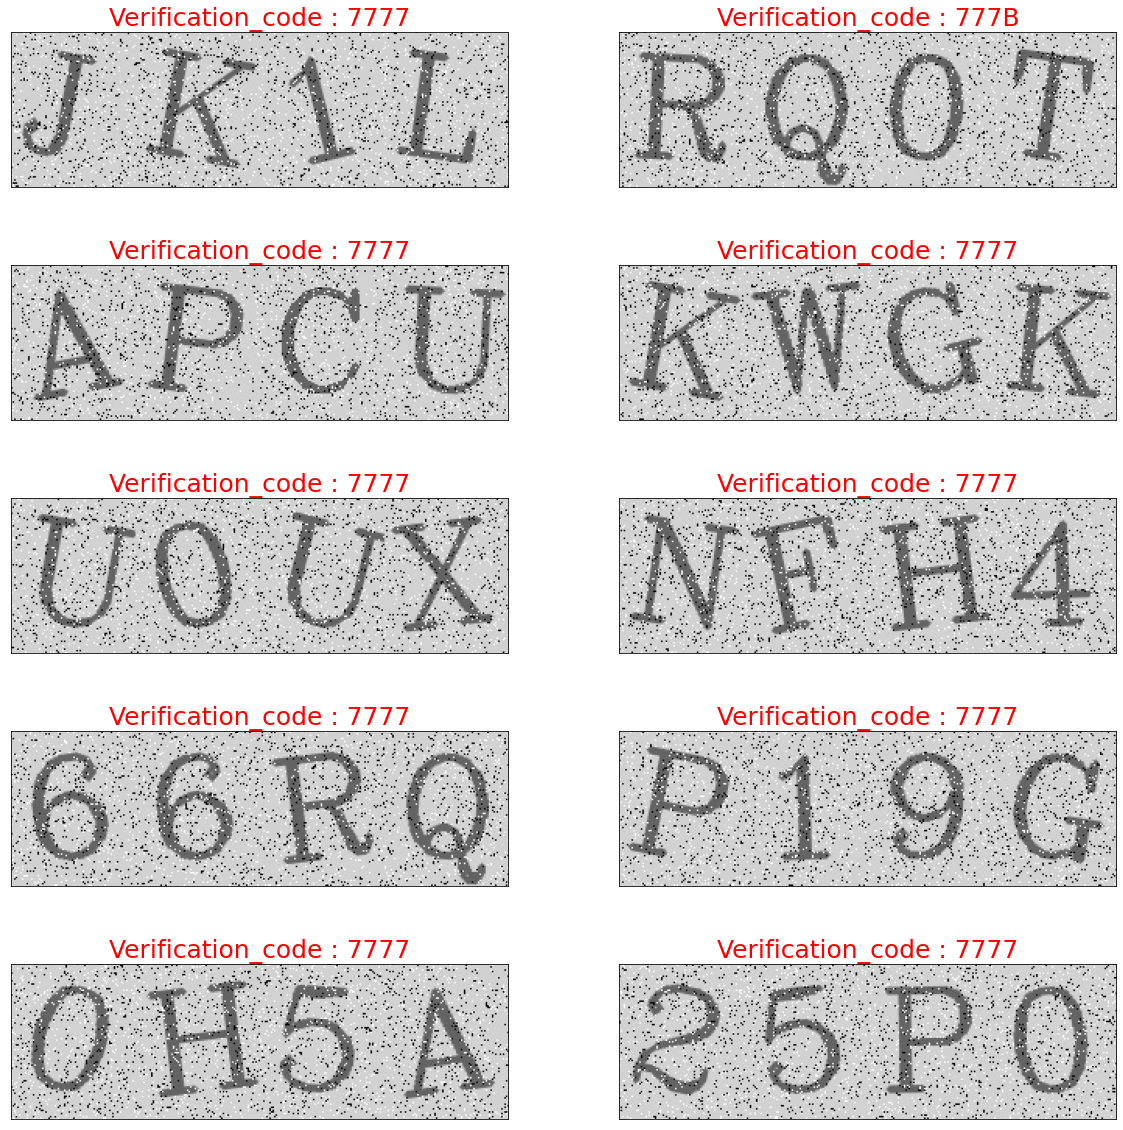

In [91]:
verification_code = load_file(verification_code_dir)
recognize_verification_code(deep_res_model, verification_code)

### Inception GoogLe-NET

In [73]:
for batch_idx , (data, target) in enumerate(train_loader):
    print(target)

tensor([ 3, 27, 21, 10,  4, 32, 20,  0,  8, 24, 23,  6, 31, 22, 16, 17, 13, 19,
        22, 16, 18,  1, 15, 16, 35, 12, 35, 16,  2,  3,  3, 34])
tensor([29,  7, 27, 12, 14, 28, 11, 13, 23,  7,  2, 18, 27, 15, 22, 24, 20,  7,
        24, 20,  4,  5,  5,  9, 24, 12, 28, 33, 16, 24,  4, 11])
tensor([31, 26, 28,  9, 10, 30, 11,  5, 14, 32,  1, 31, 24,  4, 31, 12,  6, 12,
        16, 11, 14,  7,  9, 18,  2,  9, 23, 34, 34,  8,  8,  7])
tensor([33, 11, 31, 33, 20, 35, 17, 33, 29, 21, 33, 14,  4, 28,  5, 12,  2, 28,
         3, 10, 13, 26, 33, 27, 28, 18, 34, 24, 17, 32,  5, 19])
tensor([33, 35, 26, 28,  0, 34, 15,  1,  8,  0, 10, 14,  0,  3, 10, 24, 31,  1,
         2,  4, 11,  7, 10, 21,  1, 20,  5, 24,  2, 21,  3, 11])
tensor([10, 27,  9, 18,  2, 18, 30, 13, 25, 21, 35,  8, 26, 14, 26, 28, 30, 32,
        34, 29, 28, 15, 14, 35,  3, 15,  6,  0, 19, 19, 34, 15])
tensor([ 1, 14, 33,  2, 31, 13,  3, 25, 29, 22, 31,  0, 19,  6, 20, 20, 19,  2,
         7, 26, 33, 31, 18, 29, 35, 14, 26, 29, 13

In [74]:
len(char_dict)

36

In [89]:
resnet = torchvision.models.resnet18(pretrained=True)